# Extract Names from the SST-2 Dataset 

In this notebook, we extract names from the train and test set of the SST-2 dataset. We use these for certain CheckList capabilities, to augment test instances with names encountered in the training set. 

## Load Data

In [3]:
from collections import defaultdict
from datasets import list_datasets, load_dataset, list_metrics, load_metric
from tqdm import tqdm
from transformers import AutoTokenizer

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import spacy

nlp = spacy.load("en_core_web_sm")

In [5]:
sst2_dataset = load_dataset('glue', 'sst2')

Reusing dataset glue (/Users/urjakhurana/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [10]:
tokenizer = AutoTokenizer.from_pretrained('albert-large-v2')

In [11]:
tokenized_dataset = sst2_dataset.map(lambda x: tokenizer(x['sentence']), batched=True)

Loading cached processed dataset at /Users/urjakhurana/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-102ed9c9b7bf0f7f.arrow
Loading cached processed dataset at /Users/urjakhurana/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-8005d9d0bc08d5a9.arrow
Loading cached processed dataset at /Users/urjakhurana/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-98f2e2da9f4a1157.arrow


In [13]:
sst2_dataset.num_rows, sst2_dataset.num_columns, sst2_dataset.column_names, sst2_dataset

({'train': 67349, 'validation': 872, 'test': 1821},
 {'train': 3, 'validation': 3, 'test': 3},
 {'train': ['idx', 'label', 'sentence'],
  'validation': ['idx', 'label', 'sentence'],
  'test': ['idx', 'label', 'sentence']},
 DatasetDict({
     train: Dataset({
         features: ['sentence', 'label', 'idx'],
         num_rows: 67349
     })
     validation: Dataset({
         features: ['sentence', 'label', 'idx'],
         num_rows: 872
     })
     test: Dataset({
         features: ['sentence', 'label', 'idx'],
         num_rows: 1821
     })
 }))

In [15]:
# Get all the sentences with correct uppercasing since the HuggingFace dataset contains all the sentences in lowercase. 
dictionary_path = "SST-2/dictionary.txt"

with open(dictionary_path, "r") as f: 
    original_sentences = f.read().splitlines()
    
original_sentences = [h.split("|")[0] for h in original_sentences][1:]

In [35]:
len(original_sentences), len(sst2_dataset["train"]), len(sst2_dataset["test"])

(239231, 67349, 1821)

In [19]:
# Change all the sentences to lowercase so they can get matched with the datasets in HuggingFace.
lower_originals = [sent.lower() for sent in original_sentences]
lower_originals[201]

"'' bad '' is the operative word for '' bad company , '' and i do n't mean that in a good way ."

## Extracting Names from Training Set
We extract names from the training set to use this for augmenting names in the test set for a CheckList capability tests. We also save the corresponding (mean) score(s) and stds of each name that is based on the labels of the instances they occur in. This is used for different CheckList capabilities to investigate certain biases. 

In [98]:
# Get HuggingFace sentences in train. 
new_sentences = [sst2_dataset["train"][i]["sentence"] for i in range(len(sst2_dataset["train"]))]

In [100]:
# Match all the sentences in the training set from HuggingFace with its original sentence counterpart, that has correct uppercasing to detect the names. 
matched = []
for i, new_sentence in tqdm(enumerate(new_sentences)): 
    if new_sentence[:-1] in lower_originals: 
        idx = lower_originals.index(new_sentence[:-1])
        matched.append((i, original_sentences[idx]))

67349it [03:05, 363.73it/s]


In [101]:
len(matched)

66793

In [102]:
# Names that should be filtered out that refer to movies, historical figures etc.
remove_names = ["Phifer", "The Salton", "Morton", "Widowmaker", "Charlotte Sometimes", "Lothario", "Metropolis", "Xmas", "Ya-Ya", "Brit", "Graffiti Bridge", "Birthday Girl", "Reggio", "Wiseman", "Conduct", "Decasia", "Lagaan", "Harvard Man", "Kissing Jessica Stein", "Looney Tunes", "Mask", "Taxi Driver", "Braveheart", "Beautifully", "Luther", "Aliens", "Ya-Yas", "Welsh", "Asiaphiles", "Wasabi", "Brecht", "Roger Dodger", "Marshall", "Secret Ballot", "Spousal", "Indecent Proposal", "Bourne", "Yoda", "Musketeer", "Drumline", "Darkly", "John C. Walsh  Pipe Dream", "Cinema Paradiso", "Slap", "Killed", "Yellow Asphalt", "Alias Betty", "Girls Ca", "Y Tu Mamá También", "Latino", "Goliath", "Pinocchio", "C.H.O. Cho", "Monte Cristo", "Thornberrys Movie", "Gangs", "Shiner", "Ghandi", "Quite", "Taxi Driver-esque", "Fat Girl", "Maelstrom", "Das Boot", "Heidegger - and", "Patriot", "Marker", "Adobo", "Hannibal Lecter", "Eisenhower", "Bravado Kathy", "Solaris", "Ki-deok", "Snow White", "Maid", "Grenoble", "non-Bondish", "-- Conrad L. Hall", "Kangaroo Jack", "Murder", "Jiang Wen. Devils", "d'etre", "Much Ado About Something", "Watched Trains", "Strickes Back", "Happy Gilmore", "Hush", "Gift", "Lonely Boy", "Maids", "Secret Life", "Mostly Martha", "Waldo Salt Screenwriting", "Pink Floyd", "Literary", "Russian Ark", "Komediant", "Don", "Forrest Gump", "Bravado", "Audience Award", "Extreme Ops ''", "Deeds", "Bullock Bubble", "Lush", "Blob", "Chin", "Black Hawk Down", "Oscar", "Bollywood", "Divine Secrets", "Killer", "Butthead", "Brown Sugar", "Cinderella", "Prophet Jack", "Scrooge", "Elysian Fields", "Scarpia", "Spirited Away", "Margarita Happy Hour", "Bluer", "Blade", "the Marquis de Sade", "White Oleander", "Eyre", "Green Dragon", "Shakespearean", "Morvern Callar", "Benjamins", "Wendigo", "K-19", "James Bond", "Shakespeare", "Dirty Dick", "Remove Spider-Man", "CQ", "Amélie", "Breaking Out", "Blade Runner", "Signs", "Glizty", "Mummy", "Kiss", "Tso", "Kissinger", "Spider-Man", "Shrek", "Sweet Home Alabama", "Bartleby", "Spy Kids", "Fidel Castro", "Gantz", "Dirty Harry", "Bubba Ho-Tep", "Knockaround Guys", "Clearasil", "Blade II", "Jaw-droppingly", "Episode II", "Hawke", "Showgirls", "Zipper", "World Traveler", "Glass", "Hitler", "Prejudice", "Sonny", "Rifkin", "Lucky Break", "Hermocrates", "Snow Dogs", "Sugarman", "Edward Burns ' Sidewalks", "Gordy", "Midnight Run", "Run Lola Run", "Academy Award", "Jason X", "Norma Rae", "Morlocks", "Scoob", "Extreme Ops", "Retard", "Tuxedo", "Rocky", "Dahmer", "non-Britney", "Mad Love", "Make Chan", "Fatal Attraction", "Rosemary", "Crush", "Legally Blonde", "Saddam Hussein", "Ghost Ship", "Blair Witch - style", "Chips", "Twinkie", "Roses", "Aloof", "Dad", "Les Vampires", "Freddy Gets Molested", "Frankenstein", "Cinderella II", "Yi Yi", "Bland", "Mean Streets", "Harry Potter", "Kraft Macaroni", "Cliffhanger", "Buckaroo Banzai", "Crocodile Hunter", "Drunken Master", "Tootsie", "Pokémon 4ever", "Transporter", "Chai", "Collinwood", "Slack", "Macbeth", "Losin", "Wonder Bread", "Fanboy", "Femme Fatale", "Freddy Got Fingered", "Kaos", "Rollerball", "Vulgar", "Toro", "Chou Chou", "Snide", "Re-Fried", "Caddyshack", "Phoenix", "Stealing Harvard", "Fahrenheit", "Comic Book Guy", "the Reginald Hudlin", "Wild", "Rice", "Husband", "Formula", "Dark Water", "Adrift", "Ace Ventura", "Sweet Home", "Armageddon", "Starship Troopers", "Chicken", "Mad Cows", "Re-Fried Green Tomatoe", "XXX", "Time Out", "CleanFlicks", "Pokemon", "Martin Lawrence Live '", "Starts", "Citizen Kane", "Nasty", "City By", "Glitter", "Jar-Jar Binks", "X-Files", "Imagine O. Henry", "Blair Witch", "Morvern", "Whiffle-Ball", "Auschwitz II-Birkenau"]

In [103]:
# Extract all the names. Code modified from https://github.com/marcotcr/checklist/blob/master/checklist/perturb.py#L467
# Corresponding License: 
"""MIT License

Copyright (c) 2020 Marco Tulio Correia Ribeiro

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE. """

all_entities = []

for (i, original_sentence) in tqdm(matched):
    doc = nlp(original_sentence)
    for entity in doc.ents:
        ent_name = entity.text.replace("'s", "").strip()
        if entity.label_ == "PERSON" and ent_name not in remove_names:
            all_entities.append((ent_name, i))

100%|██████████| 66793/66793 [03:37<00:00, 307.50it/s]


In [105]:
len(all_entities)

5015

In [106]:
# Get all the labels for each name. 
entities_scores = defaultdict(list)

for ent in all_entities: 
    entities_scores[ent[0]].append(sst2_dataset["train"][ent[1]]["label"])

In [108]:
# Get per name the mean and std of the labels associated with it in the training set. 
entities_dict = defaultdict(dict)

for ent in entities_scores.keys(): 
    entities_dict[ent]["scores"] = entities_scores[ent]
    entities_dict[ent]["mean"] = np.mean(entities_scores[ent])
    entities_dict[ent]["std"] = np.std(entities_scores[ent])

In [109]:
entities_dict

defaultdict(dict,
            {'Karen Black': {'scores': [1], 'mean': 1.0, 'std': 0.0},
             'Ben Bratt': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Neeson': {'scores': [0, 0, 0, 0, 0], 'mean': 0.0, 'std': 0.0},
             'Robert DeNiro': {'scores': [1,
               1,
               0,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               0,
               1,
               0,
               1],
              'mean': 0.7857142857142857,
              'std': 0.41032590332414487},
             'Robert Duvall': {'scores': [1, 1, 1, 1, 1, 1],
              'mean': 1.0,
              'std': 0.0},
             'Harris': {'scores': [1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
              'mean': 0.5,
              'std': 0.5},
             'Jason Bourne': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
             'Liman': {'scores': [0, 0], 'mean': 0.0, 'std': 0.0},
             'Shafer': 

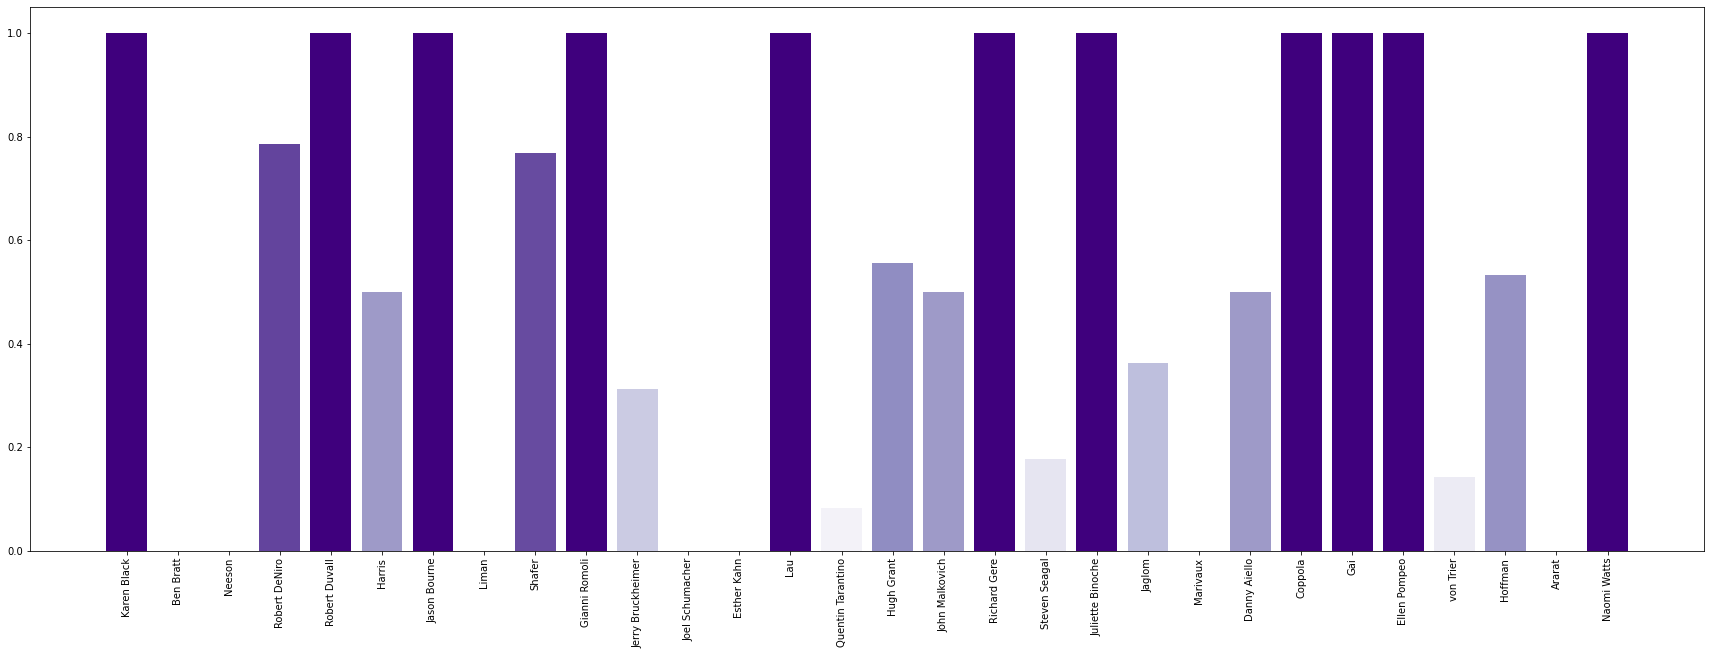

In [110]:
# Plot the mean of the labels per name for the first 30 names. 
labels = []
scores = []
stds = []
for ent in list(entities_dict.keys())[:30]: 
    labels.append(ent)
    scores.append(entities_dict[ent]["mean"])
    stds.append(entities_dict[ent]["std"] / 2)

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
my_cmap = cm.get_cmap('Purples')
plt.figure(figsize=(30,10))
y_pos = np.arange(len(scores))
plt.bar(y_pos, scores, color=my_cmap(rescale(scores)))
plt.xticks(y_pos, labels, rotation = (90))
plt.show()

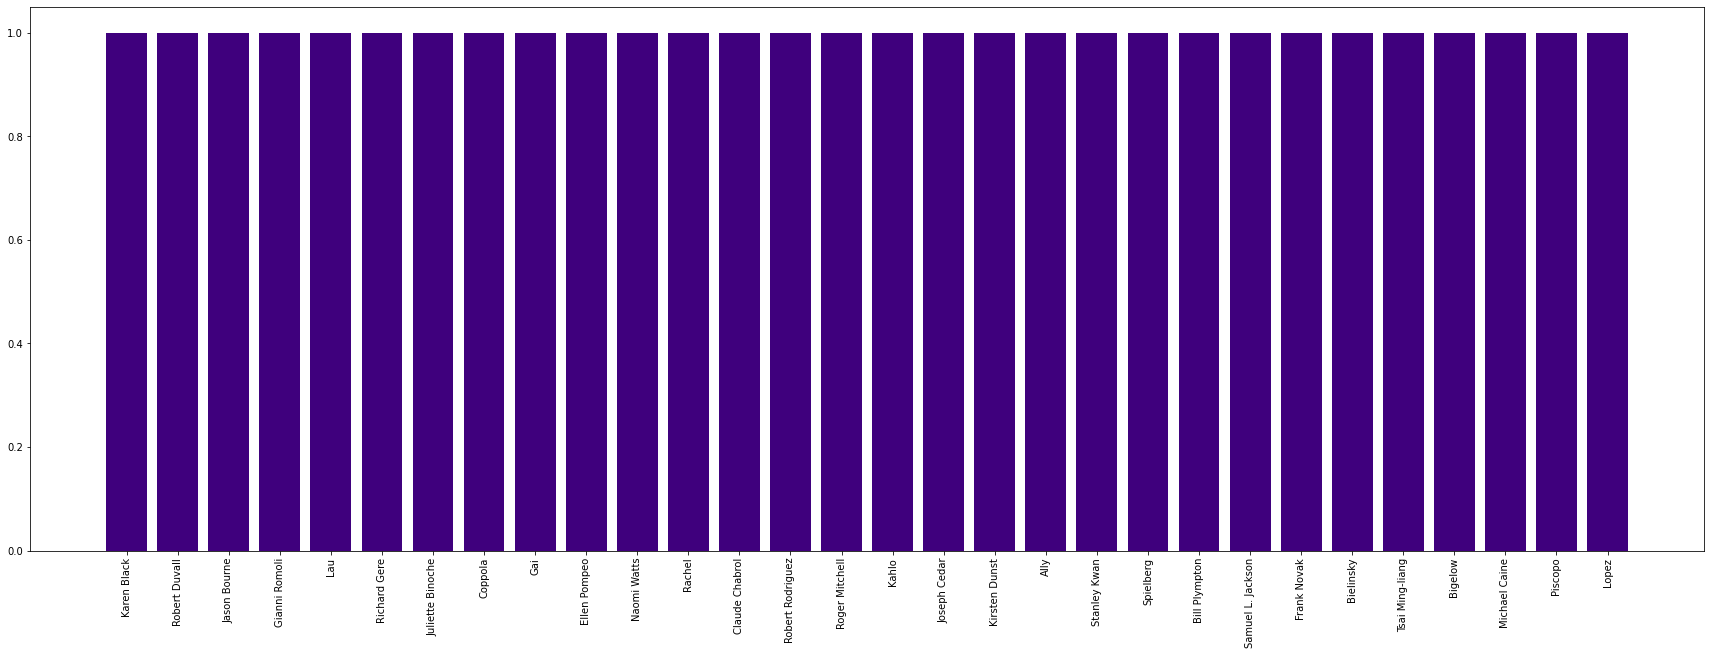

In [111]:
# Sort the names from the highest to lowest mean. 
labels = []
scores = []
stds = []
sorted_ent_dict = {k: v for k, v in sorted(entities_dict.items(), reverse=True, key=lambda item: item[1]["mean"])}
for ent in list(sorted_ent_dict.keys())[:30]: 
    labels.append(ent)
    scores.append(entities_dict[ent]["mean"])
    stds.append(entities_dict[ent]["std"])

my_cmap = cm.get_cmap('Purples')
plt.figure(figsize=(30,10))
y_pos = np.arange(len(scores))
plt.bar(y_pos, scores, color=my_cmap(scores))
plt.xticks(y_pos, labels, rotation = (90))
plt.show()

In [112]:
sorted_ent_dict

{'Karen Black': {'scores': [1], 'mean': 1.0, 'std': 0.0},
 'Robert Duvall': {'scores': [1, 1, 1, 1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Jason Bourne': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Gianni Romoli': {'scores': [1, 1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Lau': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Richard Gere': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Juliette Binoche': {'scores': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'mean': 1.0,
  'std': 0.0},
 'Coppola': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Gai': {'scores': [1, 1, 1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Ellen Pompeo': {'scores': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  'mean': 1.0,
  'std': 0.0},
 'Naomi Watts': {'scores': [1, 1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Rachel': {'scores': [1, 1, 1], 'mean': 1.0, 'std': 0.0},
 'Claude Chabrol': {'scores': [1, 1], 'mean': 1.0, 'std': 0.0},
 'Robert

In [113]:
sorted_ent_dict.keys()

dict_keys(['Karen Black', 'Robert Duvall', 'Jason Bourne', 'Gianni Romoli', 'Lau', 'Richard Gere', 'Juliette Binoche', 'Coppola', 'Gai', 'Ellen Pompeo', 'Naomi Watts', 'Rachel', 'Claude Chabrol', 'Robert Rodriguez', 'Roger Mitchell', 'Kahlo', 'Joseph Cedar', 'Kirsten Dunst', 'Ally', 'Stanley Kwan', 'Spielberg', 'Bill Plympton', 'Samuel L. Jackson', 'Frank Novak', 'Bielinsky', 'Tsai Ming-liang', 'Bigelow', 'Michael Caine', 'Piscopo', 'Lopez', 'P.T. Anderson', 'Ian Holm', 'Graham', 'Gong Li', 'Diaz', 'John Pogue', 'Angelina Jolie', 'Jonathan Swift', 'David Jacobson', 'Gulpilil', 'Pacino', 'Tim McCann', 'Jake Gyllenhaal', 'Dustin Hoffman', 'Holly Hunter', 'Brian Tufano', 'Paul Grabowsky', 'Craig Bartlett', 'Massoud', 'Tsai', 'Neil Burger', 'Christopher Walken', 'Vincent Gallo', 'John Hughes', 'Elder Bueller', 'John Sayles', 'Mike White', 'García Bernal', 'Talancón', 'Chabrol', 'Holofcener', 'Garcia', 'Brown', 'Gyllenhaal', 'Nesbitt', 'Nanette Burstein', 'Dana Janklowicz-Mann', 'Amir Mann'

In [114]:
import json

# Save the names of the training set of SST2. 
with open("names_sst2_train.json", "w") as f: 
    json.dump(sorted_ent_dict, f)

## Extracting Names from Test Set
We do the same for the names from the test set. We do this to prevent movie names or historical figures' names to be swapped with names from the training set to avoid illogical sentences. However, in this case the sentiment of the name does not matter (since we sort on negative and positive instances when creating the CheckList capabilities) hence to use the same code we use dummy labels from the training set. Hence the names are only important, the scores are not. 

In [115]:
# Get HuggingFace sentences in the test set. 
new_sentences = [sst2_dataset["test"][i]["sentence"] for i in range(len(sst2_dataset["test"]))]
len(new_sentences)

1821

In [116]:
# Match all the sentences in the test set from HuggingFace with its original sentence counterpart, that has correct uppercasing to detect the names. 
matched = []
for i, new_sentence in tqdm(enumerate(new_sentences)): 
    if new_sentence in lower_originals: 
        idx = lower_originals.index(new_sentence)
        matched.append((i, original_sentences[idx]))
len(matched)

1821it [00:01, 1333.54it/s]


1800

In [118]:
remove_names += ["La Femme Nikita", "Kappa Rho", "Burger", "Crazy", "Bubba Ho-Tep", "Mule Skinner Blues", "Fairly", "Trapped", "Les Destinees", "Mixes", "Chick Flick Hell", "Sushi", "Girls Ca n't Swim", "Flowers", "That Zang", "Motown", "Deeper Meaning", "Nicholas Nickleby", "You Need Him", "Hogan", "Blair Witch", "Morvern", "Iron Man", "Hanukkah", "Fast Runner", "Flatbush", "John Q.", "Gollum", "Conan-esque", "Time Changer", "Rookie", "El Gallo", "Dogwalker", "Pokemon 4ever", "Problem Child of IV", "Lampoon", "Borstal Boy"]

In [119]:
all_entities = []

for (i, original_sentence) in tqdm(matched):
    doc = nlp(original_sentence)
    # Find named entities, phrases and concepts
    for entity in doc.ents:
        ent_name = entity.text.replace("'s", "").strip()
        if entity.label_ == "PERSON" and ent_name not in remove_names:
            all_entities.append((ent_name, i))
len(all_entities)

100%|██████████| 1800/1800 [00:07<00:00, 250.62it/s]


368

In [120]:
entities_scores = defaultdict(list)

for ent in all_entities: 
    entities_scores[ent[0]].append(sst2_dataset["train"][ent[1]]["label"])
entities_scores

defaultdict(list,
            {'Rob Marshall': [0],
             'Behan': [1],
             'Lil Bow': [0],
             'Charlie Kaufman': [0, 0],
             'John Malkovich': [0],
             'Doug Liman': [1],
             'Denis Villeneuve': [1],
             'Benigni': [1, 0, 0],
             'Christian Ellefsen': [1],
             'Robin Williams': [1, 0],
             'Mike Epps': [0],
             'Dante Spinotti': [0],
             'Thurman': [0],
             'Lewis': [0],
             'Jacquot': [1],
             'Besson': [1],
             'Dante': [0],
             'Hu': [1],
             'Liu': [1],
             'Chaplin': [0],
             'Wim Wenders': [1],
             'Josef Bierbichler': [1],
             'Monica Bleibtreu': [1],
             'Helene Weigel': [1],
             'Lee Ross': [0],
             'Ken': [0],
             'George': [1],
             'J.K. Rowling': [0],
             'Zhao': [0, 0],
             'Stevenson': [1, 1],
             'Polanski

In [121]:
entities_dict = defaultdict(dict)

for ent in entities_scores.keys(): 
    entities_dict[ent]["scores"] = entities_scores[ent]
    entities_dict[ent]["mean"] = np.mean(entities_scores[ent])
    entities_dict[ent]["std"] = np.std(entities_scores[ent])
entities_dict

defaultdict(dict,
            {'Rob Marshall': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Behan': {'scores': [1], 'mean': 1.0, 'std': 0.0},
             'Lil Bow': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Charlie Kaufman': {'scores': [0, 0], 'mean': 0.0, 'std': 0.0},
             'John Malkovich': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Doug Liman': {'scores': [1], 'mean': 1.0, 'std': 0.0},
             'Denis Villeneuve': {'scores': [1], 'mean': 1.0, 'std': 0.0},
             'Benigni': {'scores': [1, 0, 0],
              'mean': 0.3333333333333333,
              'std': 0.4714045207910317},
             'Christian Ellefsen': {'scores': [1], 'mean': 1.0, 'std': 0.0},
             'Robin Williams': {'scores': [1, 0], 'mean': 0.5, 'std': 0.5},
             'Mike Epps': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Dante Spinotti': {'scores': [0], 'mean': 0.0, 'std': 0.0},
             'Thurman': {'scores': [0], 'mean': 0.0, 'std': 0.0

In [ ]:
sorted_ent_dict = {k: v for k, v in sorted(entities_dict.items(), reverse=True, key=lambda item: item[1]["mean"])}

In [125]:
sorted_ent_dict.keys()

dict_keys(['Behan', 'Doug Liman', 'Denis Villeneuve', 'Christian Ellefsen', 'Jacquot', 'Besson', 'Hu', 'Liu', 'Wim Wenders', 'Josef Bierbichler', 'Monica Bleibtreu', 'Helene Weigel', 'George', 'Stevenson', 'Polanski', 'Rohmer', 'Jennifer Lopez', 'Ben Affleck', 'Wahlberg', 'Stephen Kazmierski', 'Spike Lee', 'Jim Brown', 'Kapur', 'Elizabeth', 'Sen', 'John Leguizamo', 'Mike', 'Godard', 'Miike', 'Jessica Stein', 'Sam Jones', 'Todd Solondz', 'Claude Miller', 'Noyce', 'Frida Kahlo', 'Austin Powers', 'Austin', 'Wally Wolodarsky', 'Philip K. Dick', 'Culkin', 'Matthew McConaughey', 'George Clooney', 'Sam Rockwell', 'Atom Egoyan', 'Peter Sheridan', 'Ali G', 'De Niro', 'Clint Eastwood', 'Byatt', 'Schaeffer', 'Christopher', 'Huppert', 'Susan Sarandon', 'Cameron Diaz', 'Fessenden', 'Munchausen', 'Dong', 'McFarlane', 'Wollter', 'Robert Redford', 'Allen', 'Eric Byler', 'Jules', 'Jim', 'George W. Bush', 'Bruce Campbell', 'Michele', 'Stephen Earnhart', 'Sandrine', 'Jean Renoir', 'Frank Novak', 'Freundl

In [126]:
with open("names_sst2_test.json", "w") as f: 
    json.dump(sorted_ent_dict, f)